In [1]:
import pandas as pd
import numpy as np
import datetime as dt

from sklearn.metrics import mean_absolute_error

import re
import sys

import matplotlib.pyplot as plt

from sklearn.model_selection import learning_curve

from sklearn.model_selection import KFold
from ml_metrics import rmsle

import seaborn as sns
from functools import partial

from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

from sklearn.dummy import DummyRegressor
from sklearn.model_selection import ShuffleSplit

import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


np.random.seed(0)

%matplotlib inline

In [2]:
tt = pd.read_hdf('./car_price.dataset.v5.h5')

In [3]:
# helpers

def get_feats(df):
    feats = df.select_dtypes(include=[np.bool, np.int, np.int8, np.int16, np.int32, np.float, np.float32]).columns 
    return feats[ (feats != 'price_value') & (feats != 'car_id') & (feats != 'train') ].values

def get_X(df, feat_fn=get_feats):
    return df[feat_fn(df)].values

def get_y(df, target_var='price_value'):
    return df[target_var].values

def get_models():
    return [ ('dummy_median', DummyRegressor(strategy='median')) ]

def run_cv(model, X, y, folds=4, target_log=False, cv_type=KFold, success_metric=mean_absolute_error):
    cv = cv_type(n_splits=folds)
    
    scores = []
    for train_idx, test_idx in cv.split(X):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        if target_log:
            y_train = np.log(y_train)

        print(f'Fitting model (fold: {len(scores) + 1})')
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        if target_log:
            y_pred = np.exp(y_pred)
            y_pred[y_pred < 0] = 0 #czasem może być wartość ujemna

        score = success_metric(y_test, y_pred)
        scores.append( score )
        
    return np.mean(scores), np.std(scores)


def plot_learning_curve(model, title, X, y, ylim=None, cv=None, n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5), target_log=False, success_metric=mean_absolute_error):
    plt.figure(figsize=(12,8))
    plt.title(title)
    if ylim is not None: plt.ylim(*ylim)

    plt.xlabel("Training examples")
    plt.ylabel("Score")
    
    if target_log:
        y = np.log(y)
    
    def my_scorer(model, X, y):
        y_pred = model.predict(X)
        
        if target_log:
            y = np.exp(y)
            y_pred = np.exp(y_pred)
            y_pred[ y_pred<0 ] = 0
        
        return success_metric(y, y_pred)

        
    train_sizes, train_scores, test_scores = learning_curve(model, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring=my_scorer)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,  test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

    plt.legend(loc="best")
    return plt


def run(df, plot_lc=False, folds=3, ylim=(0, 10000), target_log=False, feats_fn=get_feats, success_metric=mean_absolute_error):
    X, y = get_X(df, feats_fn), get_y(df)

    for model_name, model in get_models():
        score_mean, score_std = run_cv(model, X, y, folds=folds, target_log=target_log, success_metric=success_metric)
        print("[{0}]: {1} +/-{2}".format(model_name, score_mean, score_std))
        sys.stdout.flush() #wypisujemy wynik natychmiast, bez buforowania

        if False == plot_lc: continue
        plt = plot_learning_curve(model, model_name, X, y, ylim=ylim, cv=folds, target_log=target_log, n_jobs=3, success_metric=success_metric)
        plt.show()


def train_and_predict(df, model, target_log=False, feats_fn=get_feats):
    train = df.query('train == True')
    valid = df.query('train == False')
    
    X_train, X_valid = get_X(train, feats_fn), get_X(valid, feats_fn)
    y_train = get_y(train)
    
    print(sorted(list(feats_fn(train))))
    
    if target_log:
        y_train = np.log(y_train)

    model.fit(X_train, y_train)
    y_pred = model.predict(X_valid)
        
    if target_log:
        y_pred = np.exp(y_pred)

    global_min = train.price_value.min()
    y_pred[y_pred < global_min] = global_min

    valid['price_value'] = y_pred

    #prepare to submit
    return valid[['car_id', 'price_value']]        


def feats_importance(df, model, feats_fn):
    feature_imp = pd.DataFrame(sorted(zip(model.feature_importances_,feats_fn(df))), columns=['Value','Feature'])

    plt.figure(figsize=(15, 30))
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
    plt.title('Features (avg over folds)')
    plt.tight_layout()
    plt.show()

In [4]:
# Część cech wyrzucam, bo nie robią różnicy

def feats_selected(df):
    irrelevant_or_adj = ['p_mileage', 'p_engine_capacity', 'p_engine_power', 'p_doors', 'cf_age^2', 'cf_age_inverted', 'cf_mileage_sqrt', 'cf_age_log', 'p_vat_discount', 'p_year']
    return [c for c in get_feats(df) if c not in irrelevant_or_adj]


Fitting model (fold: 1)
Fitting model (fold: 2)
Fitting model (fold: 3)
[cb]: 6123.763689618827 +/-34.92424061754343


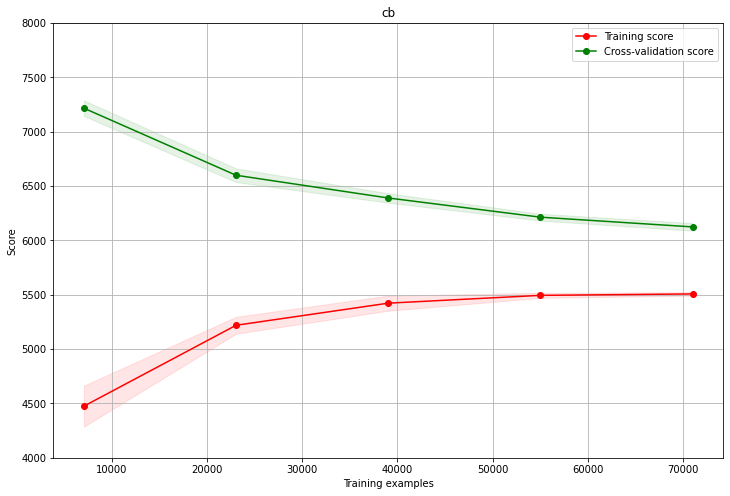

In [5]:
# Szybki model do testowanie hipotez

cb_params = dict(iterations=2000, verbose=False)

def get_models():
    return [('cb', CatBoostRegressor(**cb_params)),]

run(tt.query("train == True"), plot_lc=True, ylim=(4000, 8000), folds=3, target_log=True, feats_fn=feats_selected)


In [6]:
# Docelowy model

lgbm_params = {'verbose': 0, 'n_estimators': 5_000, 'force_col_wise': True}

def get_models():
    return [ ('lgbm', LGBMRegressor(**lgbm_params)), ]

run(tt.query("train == True"), plot_lc=False, folds=3, target_log=True, feats_fn=feats_selected)

# Parę wyników, dobrze jeśli nie tylko jest dobry wynik, ale również małe odchylenie standardowe
# estimators=2k  -> [lgbm]: 5772.951951599531 +/-38.10753452201936
# estimators=5k  -> [lgbm]: 5682.65087493143 +/-35.75347048724617
# estimators=10k -> [lgbm]: 5658.783137904568 +/-39.00954455909882
# estimators=12k -> [lgbm]: 5658.456269011979 +/-36.92554441975541
# estimators=20k -> [lgbm]: 5659.927538454529 +/-35.43195257142593

Fitting model (fold: 1)
Fitting model (fold: 2)
Fitting model (fold: 3)
[lgbm]: 5682.65087493143 +/-35.75347048724617


In [7]:
# Nieźle wygląda dla 12k estymatorów, więc trenuję na całym zbiorze

lgbm_model = LGBMRegressor(**{'verbose': 0, 'n_estimators': 12_000, 'force_col_wise': True})

res = train_and_predict(tt, model=lgbm_model, target_log=True, feats_fn=feats_selected)
res.to_csv('car_price_LGBM_12k_v5.csv', index=False)


['cf_PLN', 'cf_age', 'cf_authorized_car_seller', 'cf_cheap_make', 'cf_cheap_model', 'cf_damaged_car_seller', 'cf_doors_adj', 'cf_engine_capacity_adj', 'cf_engine_power_adj', 'cf_imported_car_seller', 'cf_leased_car_seller', 'cf_luxury_make', 'cf_luxury_model', 'cf_mileage_adj', 'cf_posted_days', 'cf_seller_address_gdansk', 'cf_seller_address_krakow', 'cf_seller_address_poznan', 'cf_seller_address_warszawa', 'cf_seller_address_wroclaw', 'cf_used_car_delear', 'cf_used_car_seller', 'cf_version_max_year', 'cf_version_min_year', 'cf_year_in_version_range', 'cf_year_vs_reg_in_days', 'cfc_body_type', 'cfc_color', 'cfc_fuel_type', 'cfc_gearbox', 'cfc_make', 'cfc_model', 'cfc_offered_by', 'cfc_origin_country', 'cfc_seller_type', 'cfc_state', 'cfc_transmission', 'cfc_version_name', 'feature_abs', 'feature_alarm', 'feature_alufelgi', 'feature_asr-(kontrola-trakcji)', 'feature_asystent-parkowania', 'feature_asystent-pasa-ruchu', 'feature_bluetooth', 'feature_cd', 'feature_centralny-zamek', 'featur

/Users/pawelg/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:113: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [10]:
# Jako ekspryment spróbowałem też 'podciąć' trochę skrajne wartości predykcji do min i max dla danej marki, jeśli tylko było dostatecznie dużo próbek

def trim_outliers(df, res, min_samples=3):
    df = df.copy()
    r = res.copy().rename(columns={'price_value': 'price_pred'})
    df = df.merge(r, on='car_id', how='left')
    
    bb = df.query('train == True')[['p_make', 'price_value']].groupby(['p_make']).agg({'price_value': (np.min, np.max, 'count')})
    bb.columns = ['price_min', 'price_max', 'price_sample_count']

    df = df.merge(bb, on=['p_make'], how='left') \
        .assign(price_value=lambda x: np.select([
            (x['price_pred'] < x['price_min']) & (x['price_sample_count'] > min_samples),
            (x['price_pred'] > x['price_max']) & (x['price_sample_count'] > min_samples),
        ], [x['price_min'], x['price_max']], x['price_pred']))
    df['diff'] = np.abs(df['price_pred'] - df['price_value'])
    tr_min = df.query('price_pred < price_min')['diff'].describe()
    tr_max = df.query('price_pred > price_max')['diff'].describe() 
    
    print(f"Min predicted price trimmed: count={tr_min['count']}, median_value={tr_min['50%']}, mean_value={tr_min['mean']}")
    print(f"Max predicted price trimmed: count={tr_max['count']}, median_value={tr_max['50%']}, mean_value={tr_max['mean']}")
    
    return df.query('train == False')[['car_id', 'price_value']]

res2 = trim_outliers(tt, res)

res2.to_csv('car_price_LGBM_12k_v5_trimmed.csv', index=False)


Min predicted price trimmed: count=19.0, median_value=115.1988899460332, mean_value=3699.218995927007
Max predicted price trimmed: count=61.0, median_value=7405.041567761218, mean_value=31193.06005964903


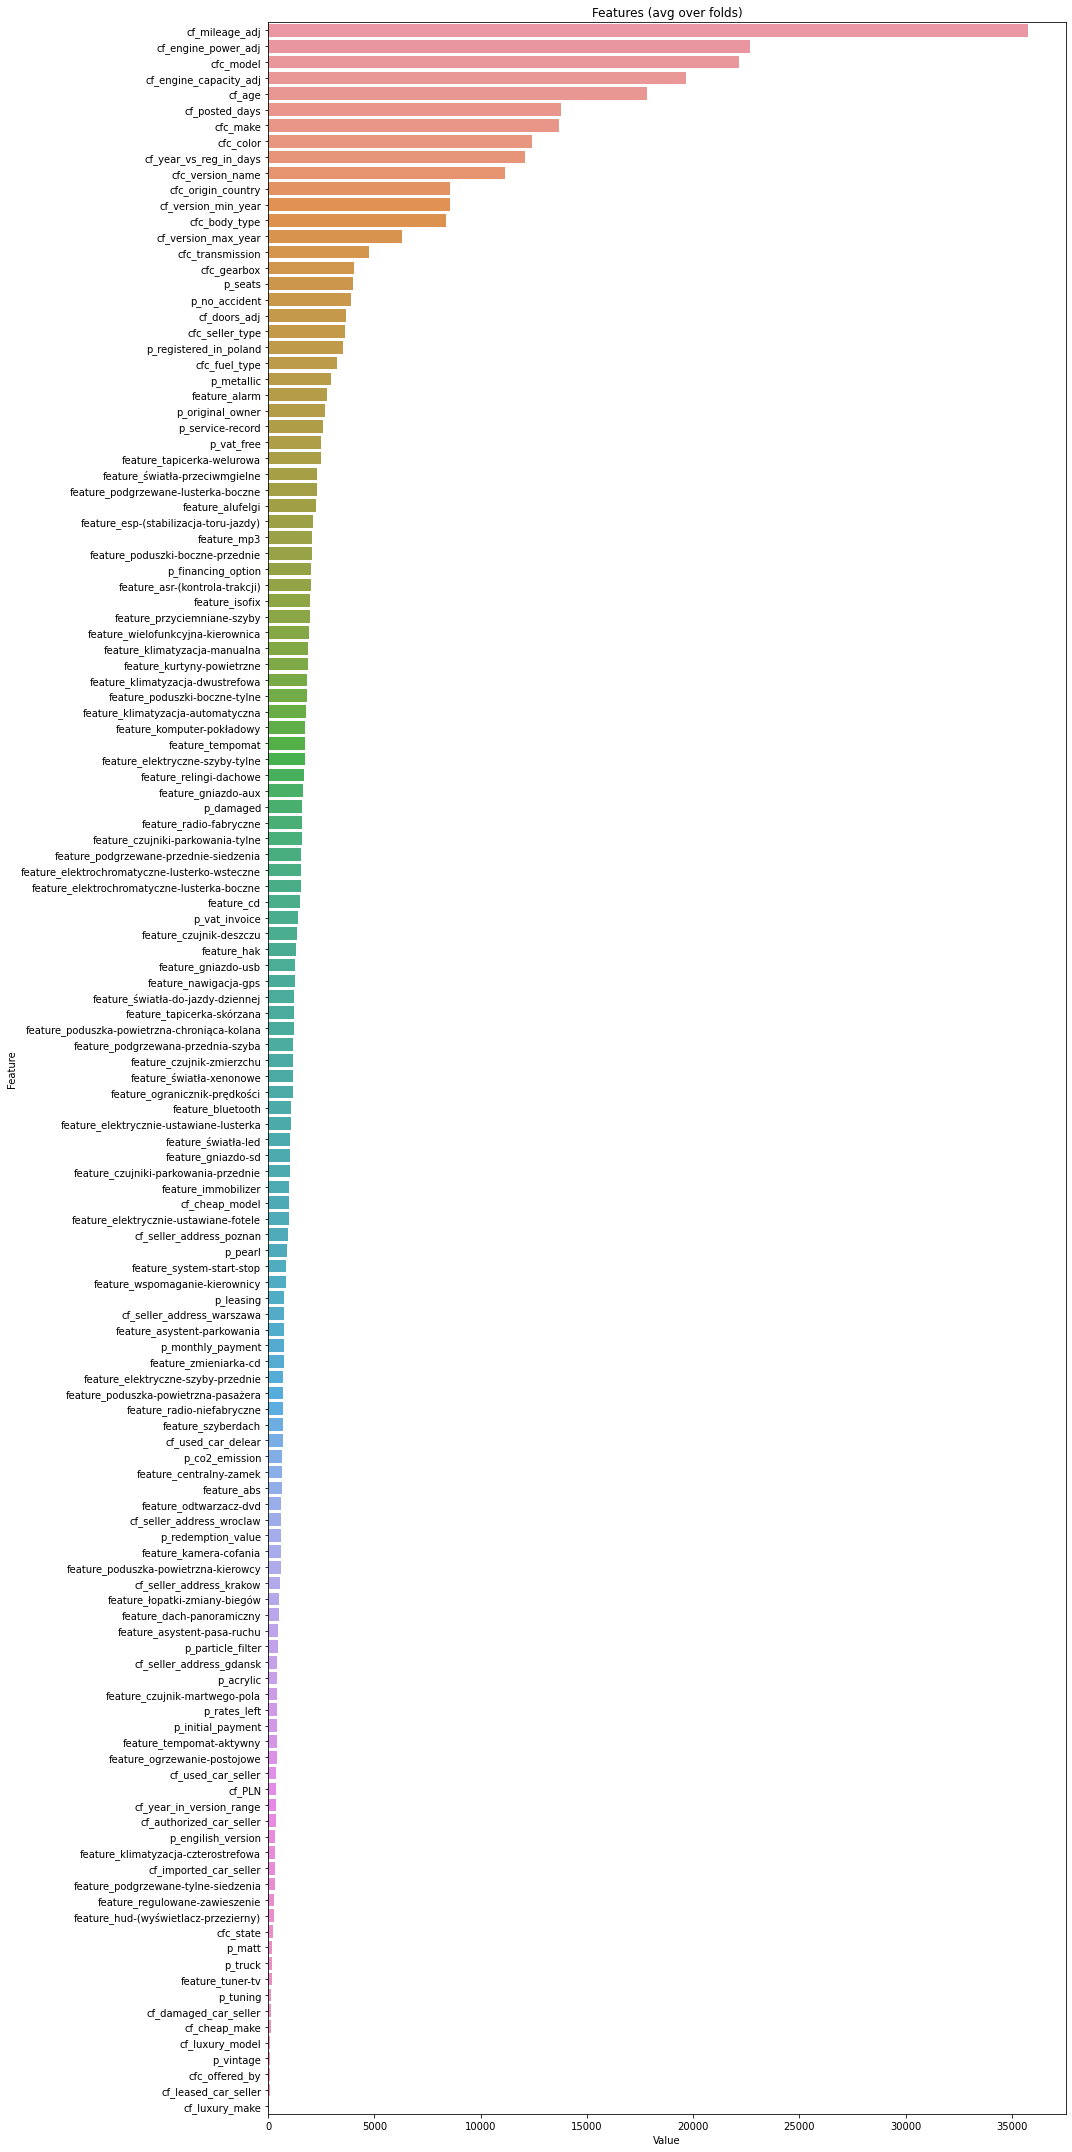

In [9]:
# Ważność cech

feats_importance(tt, lgbm_model, feats_fn=feats_selected)